In [ ]:
import os
import time
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, f1_score

from Harmonics import *

import warnings
warnings.filterwarnings("ignore")

sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=50, dpi_save=500)

from matplotlib import rcParams
rcParams["figure.dpi"] = 50
rcParams["savefig.dpi"] = 500

In [876]:
read_dir = f'../../results/Visium_DLPFC_Maynard2021/STitch3D/'
save_dir = f'../../results/Visium_DLPFC_Maynard2021/Harmonics/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [877]:
import numpy as np
import pandas as pd
import networkx as nx

def match_cluster_labels(true_labels, est_labels):
    true_labels_arr = np.array(list(true_labels))
    est_labels_arr = np.array(list(est_labels))

    org_cat = list(np.sort(list(pd.unique(true_labels))))
    est_cat = list(np.sort(list(pd.unique(est_labels))))

    B = nx.Graph()
    B.add_nodes_from([i + 1 for i in range(len(org_cat))], bipartite=0)
    B.add_nodes_from([-j - 1 for j in range(len(est_cat))], bipartite=1)

    for i in range(len(org_cat)):
        for j in range(len(est_cat)):
            weight = np.sum((true_labels_arr == org_cat[i]) * (est_labels_arr == est_cat[j]))
            B.add_edge(i + 1, -j - 1, weight=-weight)

    match = nx.algorithms.bipartite.matching.minimum_weight_full_matching(B)

    if len(org_cat) >= len(est_cat):
        return np.array([match[-est_cat.index(c) - 1] - 1 for c in est_labels_arr])
    else:
        unmatched = [c for c in est_cat if not (-est_cat.index(c) - 1) in match.keys()]
        l = []
        for c in est_labels_arr:
            if (-est_cat.index(c) - 1) in match:
                l.append(match[-est_cat.index(c) - 1] - 1)
            else:
                l.append(len(org_cat) + unmatched.index(c))
        return np.array(l)
    
    
def p2stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

### Load dataset

In [878]:
g = 'g2'
groups = {'g1': ['151507', '151508', '151509', '151510'], 
          'g2': ['151669', '151670', '151671', '151672'], 
          'g3': ['151673', '151674', '151675', '151676']}
slice_name_list = groups[g]

celltype_list_use = ['Astros_1', 'Astros_2', 'Astros_3', 
                     'Endo', 
                     'Ex_10_L2_4', 'Ex_1_L5_6', 'Ex_2_L5', 'Ex_3_L4_5', 'Ex_4_L_6', 'Ex_5_L5', 
                     'Ex_6_L4_6', 'Ex_7_L4_6', 'Ex_8_L5_6', 'Ex_9_L5_6', 
                     'Micro/Macro', 
                     'Oligos_1', 'Oligos_2', 'Oligos_3',
                     ]
celltype_list_use = sorted(celltype_list_use)

adata_list = []
for slice_name in slice_name_list:
    adata = ad.read_h5ad(read_dir + f'{slice_name}_STitch3D.h5ad')
    adata = adata[adata.obs['Manual_Annotation'].notna(), :].copy()

    # place the cell type deconvolution result in .obsm['ct_prop']
    ct_prop = adata.obs[celltype_list_use].to_numpy()
    # row_sums = ct_prop.sum(axis=1, keepdims=True)
    # ct_prop = ct_prop / row_sums
    adata.obsm['ct_prop'] = sp.csr_matrix(ct_prop)
    print(adata)
   
    adata_list.append(adata)

AnnData object with n_obs × n_vars = 3636 × 21216
    obs: 'in_tissue', 'x', 'y', 'image_row', 'image_col', 'imagerow', 'imagecol', 'Manual_Annotation', 'array_row', 'array_col', 'Astros_1', 'Astros_2', 'Astros_3', 'Endo', 'Ex_10_L2_4', 'Ex_1_L5_6', 'Ex_2_L5', 'Ex_3_L4_5', 'Ex_4_L_6', 'Ex_5_L5', 'Ex_6_L4_6', 'Ex_7_L4_6', 'Ex_8_L5_6', 'Ex_9_L5_6', 'Micro/Macro', 'Oligos_1', 'Oligos_2', 'Oligos_3'
    var: 'gene_ids', 'feature_types', 'genome', 'MT_gene', 'n_counts'
    obsm: 'latent', 'radius', 'spatial', 'spatial_aligned', 'spatial_img', 'ct_prop'
AnnData object with n_obs × n_vars = 3484 × 20999
    obs: 'in_tissue', 'x', 'y', 'image_row', 'image_col', 'imagerow', 'imagecol', 'Manual_Annotation', 'array_row', 'array_col', 'Astros_1', 'Astros_2', 'Astros_3', 'Endo', 'Ex_10_L2_4', 'Ex_1_L5_6', 'Ex_2_L5', 'Ex_3_L4_5', 'Ex_4_L_6', 'Ex_5_L5', 'Ex_6_L4_6', 'Ex_7_L4_6', 'Ex_8_L5_6', 'Ex_9_L5_6', 'Micro/Macro', 'Oligos_1', 'Oligos_2', 'Oligos_3'
    var: 'gene_ids', 'feature_types', 'genome',

### Run model

In [879]:
refine_k_dict = {'g1': 10, 'g2': 5, 'g3': 0}
model = Harmonics_Model(adata_list, 
                        slice_name_list,
                        cond_list=None,  # default
                        cond_name_list=None,  # default
                        concat_label='slice_name',  # default
                        proportion_label='ct_prop', 
                        refine_k=refine_k_dict[g],
                        seed=1234,  # default
                        parallel=True,  # default 
                        verbose=True,  # default
                        )

Dataset comprises 4 slices, 15101 cells/spots in total.


In [880]:
model.preprocess(ct_key=None,  # use celltype deconvolution result, do not need celltype
                 spatial_key='spatial',  # default
                 method='joint',  # default
                 n_step=2,
                 n_neighbors=20,  # default
                 cut_percentage=99,  # default
                 )

Generating Delaunay neighbor graph...


100%|██████████| 4/4 [00:00<00:00, 20.26it/s]


All done!

Performing graph completion...


100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

All done!

Dataset comprises 18 cell types.

Calculating cell type distribution for microenvironments...
Microenvironments comprise 21.02 cells/spots on average. 
Minimum: 20, Maximum: 25



In [881]:
model.initialize_clusters(dim_reduction=True,  # default
                          explained_var=None,  # default
                          n_components=None,  # default
                          n_components_max=100,  # default
                          standardize=True,  # default
                          method='kmeans',  # default 
                          Qmax=20,  # default  
                          )

Performing dimension reduction...
Returning 18 principal components.

Initializing niches...
20 initial niches defined.



In [882]:
model.hier_dist_match(assign_metric='jsd',  # default
                      weighted_merge=True,  # default
                      max_iters=100,  # default 
                      tol=1e-4,  # default 
                      test_kmeans=False,  # default
                      )

Starting from 20 cell niches...

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


 14%|█▍        | 14/100 [00:00<00:03, 27.09it/s]


Distribution of cell niches (centers) converge at iteration 15.
20 cell niches left.
Merging cell niche 12 and cell niche 4...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


  2%|▏         | 2/100 [00:00<00:04, 23.68it/s]


Distribution of cell niches (centers) converge at iteration 3.
19 cell niches left.
Merging cell niche 19 and cell niche 12...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]


  5%|▌         | 5/100 [00:00<00:03, 26.87it/s]


Distribution of cell niches (centers) converge at iteration 6.
18 cell niches left.
Merging cell niche 7 and cell niche 19...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18]


  9%|▉         | 9/100 [00:00<00:02, 31.37it/s]


Distribution of cell niches (centers) converge at iteration 10.
17 cell niches left.
Merging cell niche 16 and cell niche 7...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18]


  2%|▏         | 2/100 [00:00<00:03, 27.22it/s]


Distribution of cell niches (centers) converge at iteration 3.
16 cell niches left.
Merging cell niche 15 and cell niche 1...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18]


  4%|▍         | 4/100 [00:00<00:02, 37.54it/s]

Distribution of cell niches (centers) converge at iteration 7.

  6%|▌         | 6/100 [00:00<00:02, 33.57it/s]



15 cell niches left.
Merging cell niche 9 and cell niche 14...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 5, 6, 8, 9, 10, 11, 13, 15, 16, 17, 18]


  3%|▎         | 3/100 [00:00<00:02, 33.55it/s]


Distribution of cell niches (centers) converge at iteration 4.
14 cell niches left.
Merging cell niche 9 and cell niche 5...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 6, 8, 9, 10, 11, 13, 15, 16, 17, 18]


  5%|▌         | 5/100 [00:00<00:02, 36.55it/s]


Strictly converge at iteration 6.
13 cell niches left.
Merging cell niche 9 and cell niche 18...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 6, 8, 9, 10, 11, 13, 15, 16, 17]


  7%|▋         | 7/100 [00:00<00:02, 40.12it/s]


Distribution of cell niches (centers) converge at iteration 8.
12 cell niches left.
Merging cell niche 0 and cell niche 15...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 6, 8, 9, 10, 11, 13, 16, 17]


  6%|▌         | 6/100 [00:00<00:02, 34.60it/s]

Distribution of cell niches (centers) converge at iteration 7.


11 cell niches left.
Merging cell niche 6 and cell niche 16...
Done!

Assigning cells to cell niche...
Current state: [0, 2, 3, 6, 8, 9, 10, 11, 13, 17]


  4%|▍         | 4/100 [00:00<00:03, 30.97it/s]


Distribution of cell niches (centers) converge at iteration 5.
10 cell niches left.
Merging cell niche 6 and cell niche 0...
Done!

Assigning cells to cell niche...
Current state: [2, 3, 6, 8, 9, 10, 11, 13, 17]


  6%|▌         | 6/100 [00:00<00:02, 35.71it/s]


Distribution of cell niches (centers) converge at iteration 7.
9 cell niches left.
Merging cell niche 6 and cell niche 10...
Done!

Assigning cells to cell niche...
Current state: [2, 3, 6, 8, 9, 11, 13, 17]


  4%|▍         | 4/100 [00:00<00:02, 38.17it/s]


Distribution of cell niches (centers) converge at iteration 5.
8 cell niches left.
Merging cell niche 17 and cell niche 2...
Done!

Assigning cells to cell niche...
Current state: [3, 6, 8, 9, 11, 13, 17]


  6%|▌         | 6/100 [00:00<00:02, 43.00it/s]


Distribution of cell niches (centers) converge at iteration 7.
7 cell niches left.
Merging cell niche 6 and cell niche 3...
Done!

Assigning cells to cell niche...
Current state: [6, 8, 9, 11, 13, 17]


  5%|▌         | 5/100 [00:00<00:02, 41.78it/s]


Distribution of cell niches (centers) converge at iteration 6.
6 cell niches left.
Merging cell niche 13 and cell niche 6...
Done!

Assigning cells to cell niche...
Current state: [8, 9, 11, 13, 17]


  4%|▍         | 4/100 [00:00<00:02, 39.67it/s]

Distribution of cell niches (centers) converge at iteration 7.

  6%|▌         | 6/100 [00:00<00:02, 35.89it/s]



5 cell niches left.
Merging cell niche 17 and cell niche 8...
Done!

Assigning cells to cell niche...
Current state: [9, 11, 13, 17]


  3%|▎         | 3/100 [00:00<00:02, 34.78it/s]


Distribution of cell niches (centers) converge at iteration 4.
4 cell niches left.
Merging cell niche 11 and cell niche 13...
Done!

Assigning cells to cell niche...
Current state: [9, 11, 17]


  0%|          | 0/100 [00:00<?, ?it/s]

Strictly converge at iteration 4.


  3%|▎         | 3/100 [00:00<00:02, 35.77it/s]


3 cell niches left.
Merging cell niche 9 and cell niche 17...
Done!

Assigning cells to cell niche...
Current state: [9, 11]


  2%|▏         | 2/100 [00:00<00:02, 34.99it/s]


Distribution of cell niches (centers) converge at iteration 3.
2 cell niches left.
Niche count no more than 2.

Finished!



In [883]:
if g == 'g2':
    n_cluster = 5
else: 
    n_cluster = 7
adata_list, adata_concat = model.select_solution(n_niche=n_cluster, 
                                                 niche_key='niche_label',  # default 
                                                 auto=False, 
                                                 metric='jsd',  # default
                                                 threshold=0.1,  # default
                                                 return_adata=True,  # default
                                                 plot=True,  # default
                                                 save=False,  # default
                                                 fig_size=(10, 6),  # default
                                                 save_dir=save_dir, 
                                                 file_name=f'score_vs_nichecount_basic.pdf',
                                                 )

Selecting solution based on specified niche count...
Done!



In [ ]:
# adata_concat.write_h5ad(save_dir + f'Harmonics_result_{g}_0.h5ad')

In [ ]:
# adata_concat = ad.read_h5ad(save_dir + f'Harmonics_result_{g}_0.h5ad')
adata_concat_new = adata_concat.copy()
adata_concat_new

AnnData object with n_obs × n_vars = 15101 × 19177
    obs: 'in_tissue', 'x', 'y', 'image_row', 'image_col', 'imagerow', 'imagecol', 'Manual_Annotation', 'array_row', 'array_col', 'Astros_1', 'Astros_2', 'Astros_3', 'Endo', 'Ex_10_L2_4', 'Ex_1_L5_6', 'Ex_2_L5', 'Ex_3_L4_5', 'Ex_4_L_6', 'Ex_5_L5', 'Ex_6_L4_6', 'Ex_7_L4_6', 'Ex_8_L5_6', 'Ex_9_L5_6', 'Micro/Macro', 'Oligos_1', 'Oligos_2', 'Oligos_3', 'slice_name', 'n_neighbors', 'niche_label'
    uns: 'niche_cell_count', 'niche_dist', 'niche_label_summary'
    obsm: 'ct_prop', 'latent', 'micro_dist', 'proportion', 'radius', 'spatial', 'spatial_aligned', 'spatial_img'

In [886]:
domains = ['Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'WM']
domain_color_dict = {f'{domains[i]}': sns.color_palette()[i] for i in range(len(domains))}

niche_color_dict = {str(k): sns.color_palette()[k] for k in range(len(domains))}

ct_colors = sns.color_palette('tab20', len(celltype_list_use))
ct_color_dict = {celltype_list_use[k]: ct_colors[k] for k in range(len(celltype_list_use))}

In [887]:
# latent = adata_concat_new.obsm['latent'].copy()
# gmm = GaussianMixture(n_components=n_cluster, random_state=1234)
# gmm.fit(latent)
# adata_concat_new.obs['niche_label_STitch3D'] = gmm.predict(latent)
# adata_concat_new.obs['niche_label_STitch3D'] = adata_concat_new.obs['niche_label_STitch3D'].astype(str)

In [888]:
if g == 'g2':
    matched_clusters = match_cluster_labels(adata_concat_new.obs['Manual_Annotation'], adata_concat_new.obs[f'niche_label']) + 2
else:
    matched_clusters = match_cluster_labels(adata_concat_new.obs['Manual_Annotation'], adata_concat_new.obs[f'niche_label'])
matched_labels = [domains[idx] if idx < len(domains) else 'Unmatched' for idx in matched_clusters]
adata_concat_new.obs[f'matched_cluster'] = [str(label) for label in matched_clusters]
adata_concat_new.obs[f'matched_label'] = matched_labels

start = 0
for i in range(len(adata_list)):
    end = start + adata_list[i].shape[0]
    adata = adata_concat_new[start:end].copy()
    adata_list[i].obs['matched_cluster'] = adata_concat_new[start:end].obs['matched_cluster'].copy()
    adata_list[i].obs['matched_label'] = adata_concat_new[start:end].obs['matched_label'].copy()
    adata_list[i].obs['niche_label'] = adata_concat_new[start:end].obs['niche_label'].copy()
    start = end

151669
ARI:  0.7913, AMI:  0.7077, mF1:  0.6085, wF1:  0.7823
ARI: 0.7913 AMI: 0.7077 mF1: 0.6085 wF1: 0.7823


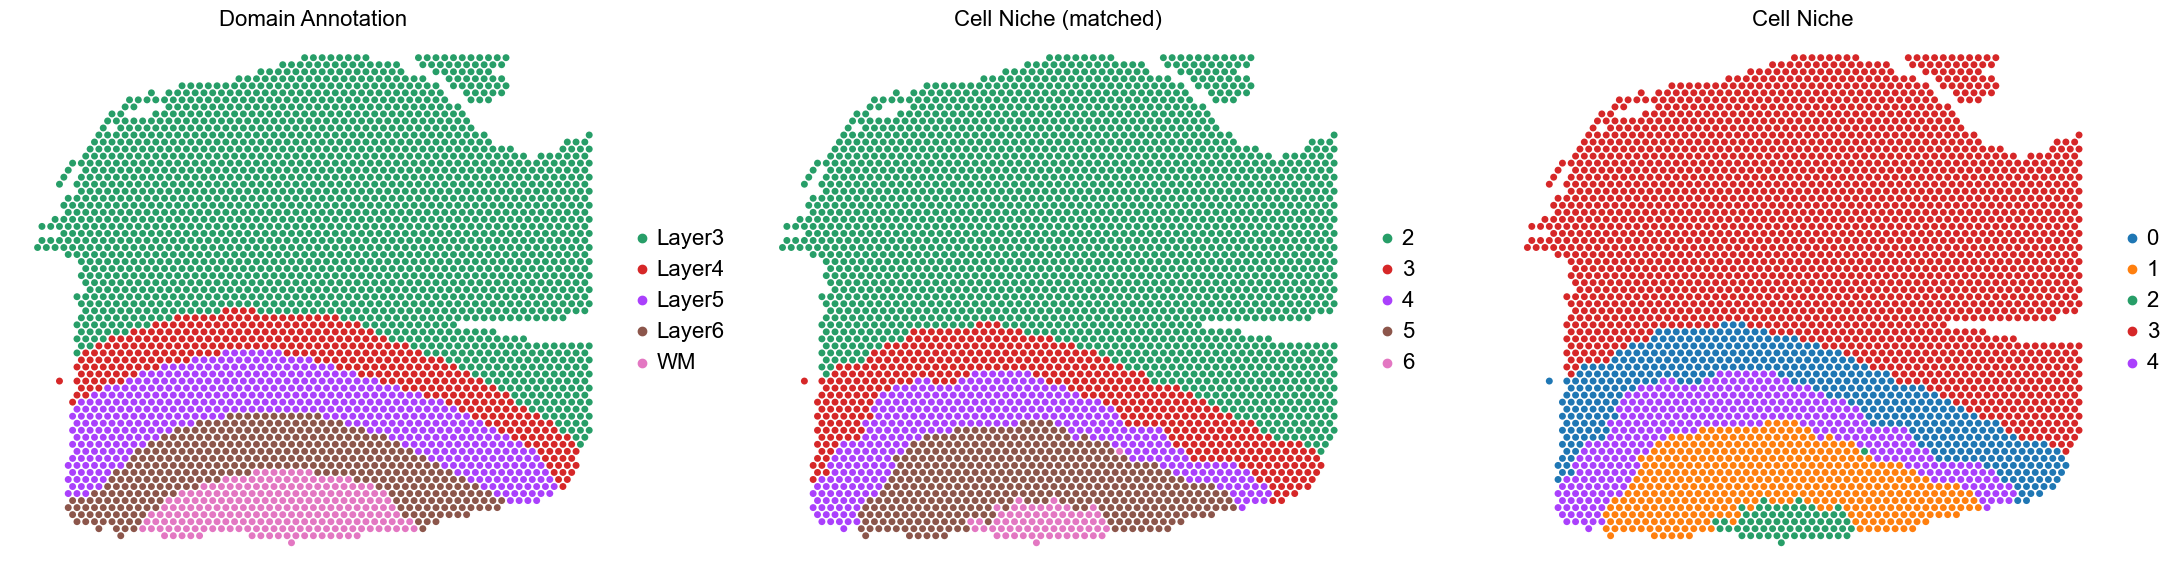

151670
ARI:  0.8251, AMI:  0.7246, mF1:  0.5587, wF1:  0.7838
ARI: 0.8251 AMI: 0.7246 mF1: 0.5587 wF1: 0.7838


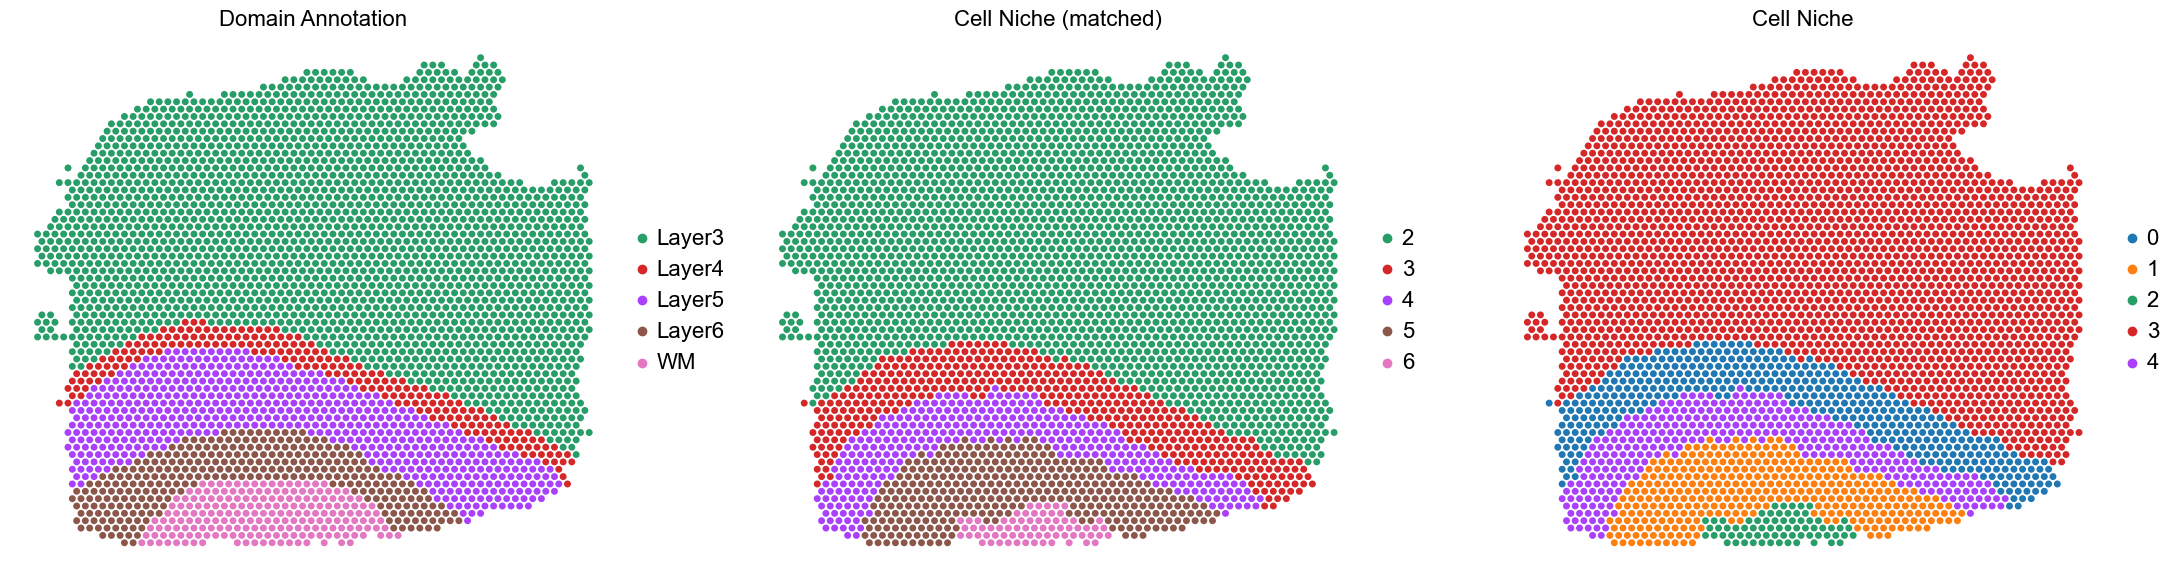

151671
ARI:  0.8132, AMI:  0.7465, mF1:  0.7688, wF1:  0.8528
ARI: 0.8132 AMI: 0.7465 mF1: 0.7688 wF1: 0.8528


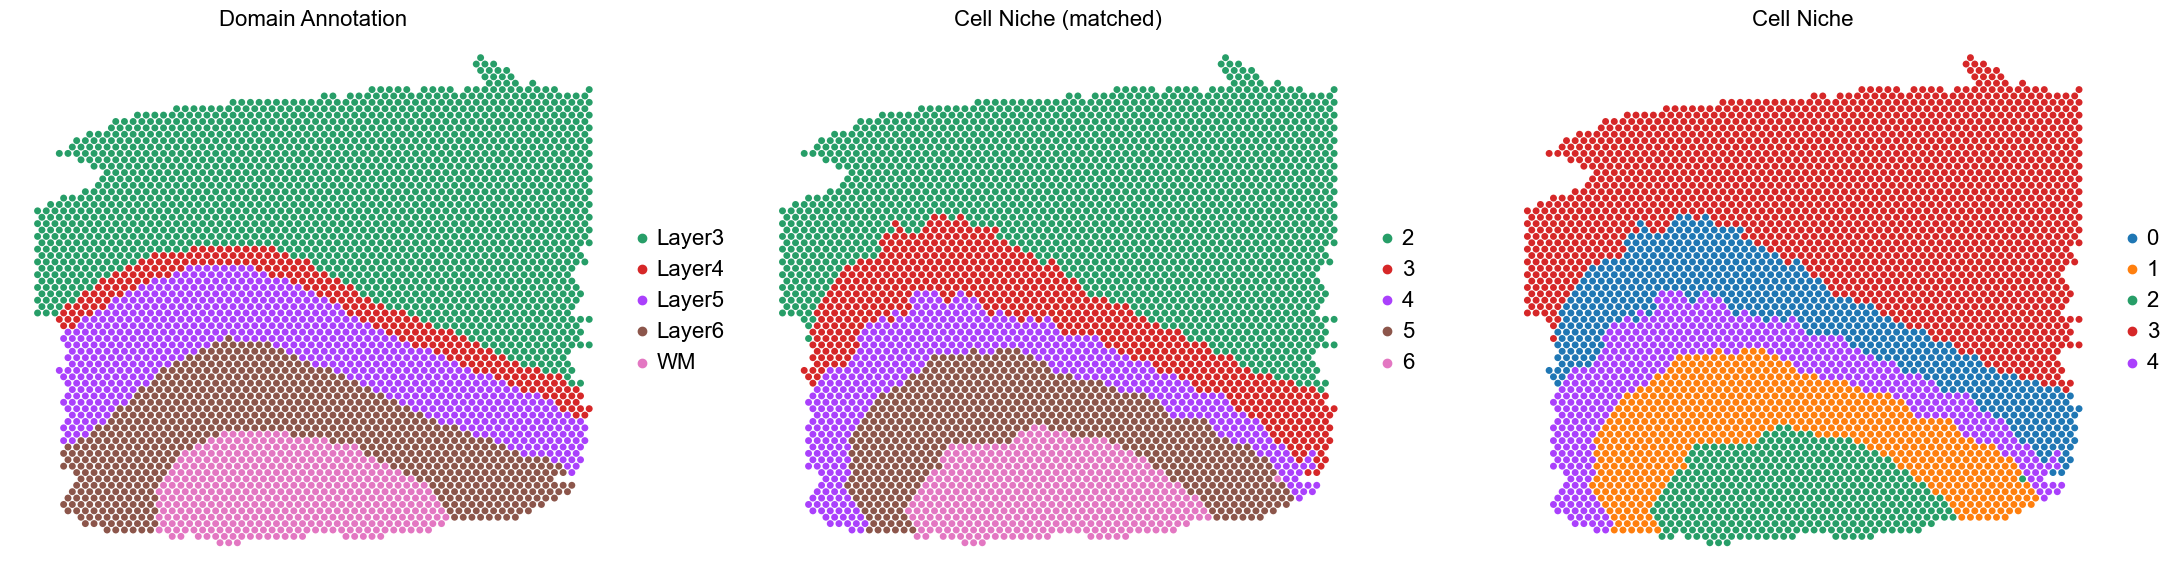

151672
ARI:  0.7649, AMI:  0.7401, mF1:  0.7179, wF1:  0.7939
ARI: 0.7649 AMI: 0.7401 mF1: 0.7179 wF1: 0.7939


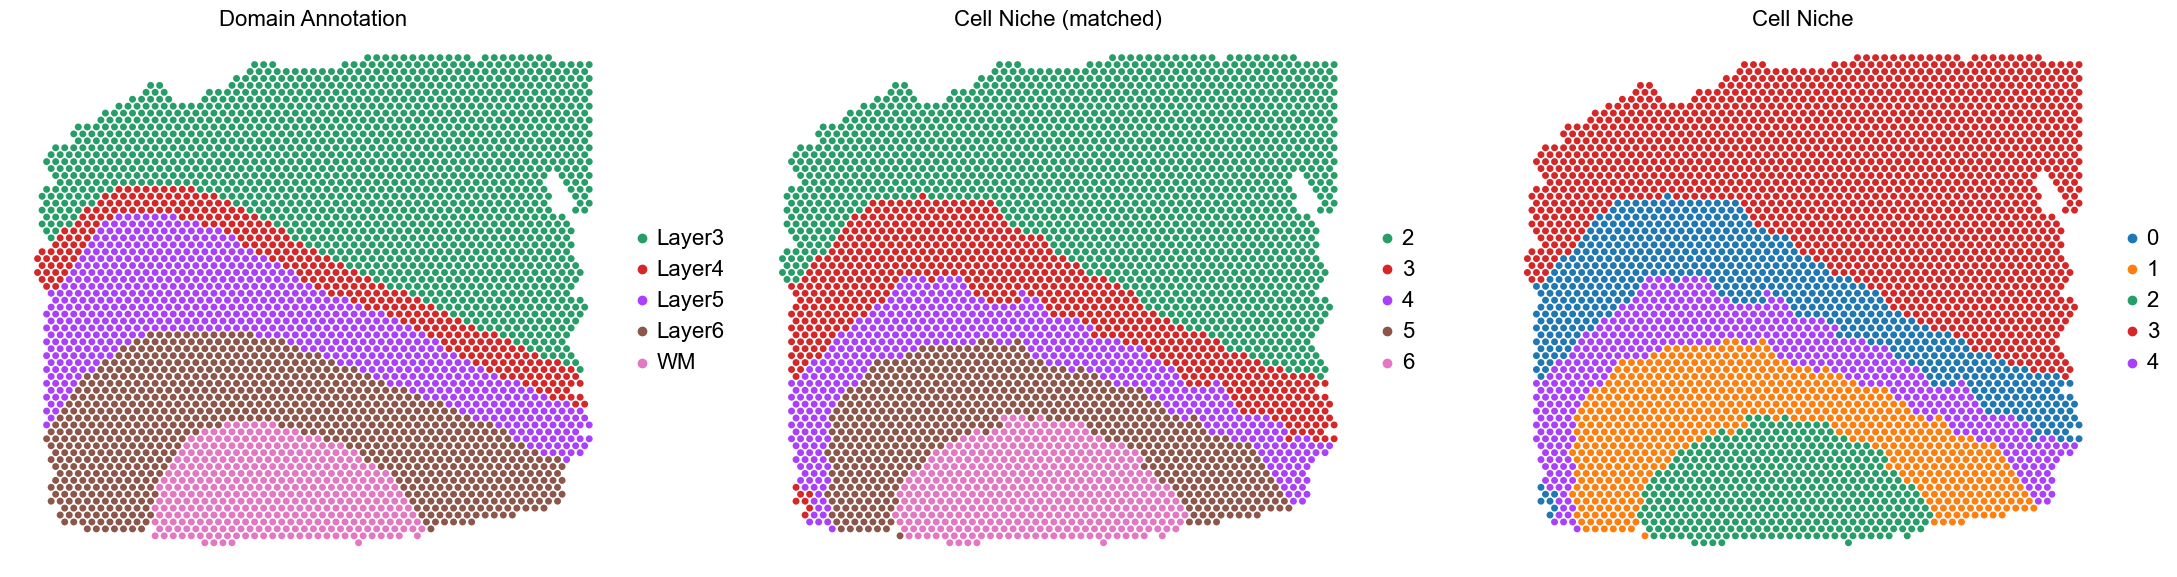

Median: ARI: 0.8023 AMI: 0.7323 mF1: 0.6632 wF1: 0.7888
Mean: ARI: 0.7986 AMI: 0.7297 mF1: 0.6635 wF1: 0.8032


In [889]:
ari_scores = []
ami_scores = []
mf1_scores = []
wf1_scores = []

for i in range(len(slice_name_list)):
    
    print(slice_name_list[i])
    adata = adata_list[i].copy()

    ari = adjusted_rand_score(adata.obs['Manual_Annotation'], adata.obs['matched_cluster'])
    ami = adjusted_mutual_info_score(adata.obs['Manual_Annotation'], adata.obs['matched_cluster'])
    f1_macro = f1_score(adata.obs['Manual_Annotation'], adata.obs['matched_label'], average='macro')
    f1_weighted = f1_score(adata.obs['Manual_Annotation'], adata.obs['matched_label'], average='weighted')
    print(f"ARI: {ari: .4f}, AMI: {ami: .4f}, mF1: {f1_macro: .4f}, wF1: {f1_weighted: .4f}")

    ari_scores.append(ari)
    ami_scores.append(ami)
    mf1_scores.append(f1_macro)
    wf1_scores.append(f1_weighted)
    print(f'ARI:{ari: .4f} AMI:{ami: .4f} mF1:{f1_macro: .4f} wF1:{f1_weighted: .4f}')
    
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    sc.pl.embedding(adata, basis='spatial', palette=domain_color_dict, color='Manual_Annotation', 
                    ax=axes[0], s=100, show=False, frameon=False, title='Domain Annotation', legend_fontsize=16)
    axes[0].set_title('Domain Annotation', fontsize=16)
    axes[0].invert_yaxis()

    sc.pl.embedding(adata, basis='spatial', palette=niche_color_dict, color='matched_cluster', 
                    ax=axes[1], s=100, show=False, frameon=False, title='Cell Niche (matched)', legend_fontsize=16)
    axes[1].set_title('Cell Niche (matched)', fontsize=16)
    axes[1].invert_yaxis()

    sc.pl.embedding(adata, basis='spatial', palette=niche_color_dict, color='niche_label', 
                    ax=axes[2], s=100, show=False, frameon=False, title='Cell Niche', legend_fontsize=16)
    axes[2].set_title('Cell Niche', fontsize=16)
    axes[2].invert_yaxis()

    plt.tight_layout()
    plt.show()
    
print(f'Median: ARI:{np.median(ari_scores): .4f} AMI:{np.median(ami_scores): .4f} mF1:{np.median(mf1_scores): .4f} wF1:{np.median(wf1_scores): .4f}')
print(f'Mean: ARI:{np.mean(ari_scores): .4f} AMI:{np.mean(ami_scores): .4f} mF1:{np.mean(mf1_scores): .4f} wF1:{np.mean(wf1_scores): .4f}')

### Cell type composition

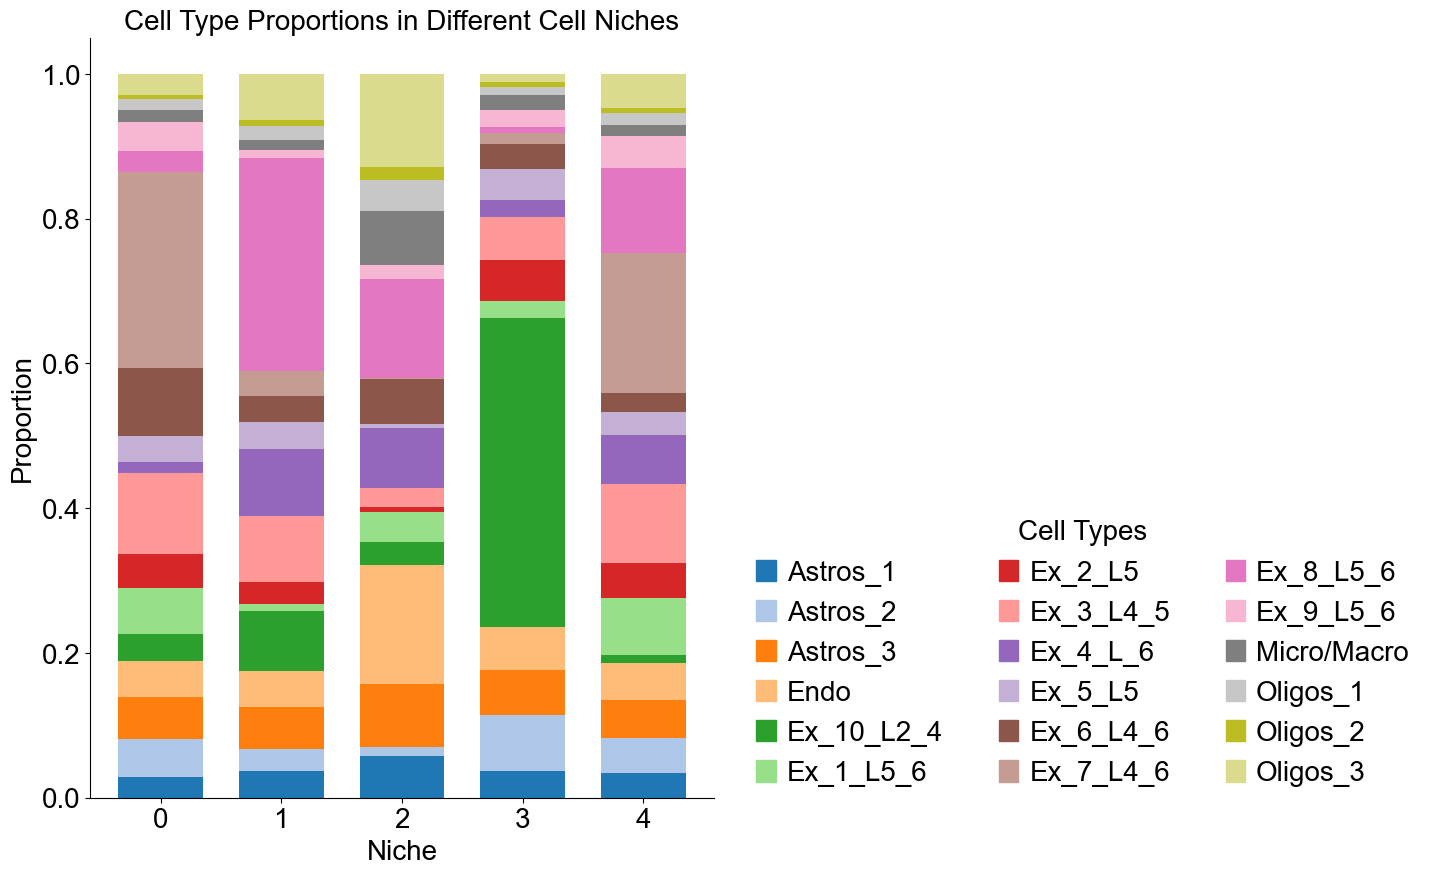

In [890]:
niche_labels = adata_concat_new.uns['niche_label_summary'].copy()
ct_labels = celltype_list_use
niche_dist = adata_concat_new.uns['niche_dist'].toarray().copy()
cell_count_niche = adata_concat_new.uns['niche_cell_count'].copy()

fig, ax = plt.subplots(figsize=(8, 10))
bar_width = 0.7
n_niches, n_cell_types = niche_dist.shape

x = np.arange(n_niches)

for j in range(n_cell_types):
    bottom = np.sum(niche_dist[:, :j], axis=1)
    ax.bar(x,                         
           niche_dist[:, j],            
           bottom=bottom,               
           width=bar_width,
           color=ct_color_dict[ct_labels[j]],
           label=ct_labels[j])

ax.set_ylabel('Proportion', fontsize=20)
ax.set_xlabel('Niche', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(niche_labels, rotation=0, ha='center')
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

handles = [
    mpatches.Patch(color=color, label=ct)
    for ct, color in zip(celltype_list_use, ct_colors)
]

ax.legend(handles=handles, title='Cell Types', loc=(1.05, 0.0), frameon=False, handleheight=0.8, 
          handlelength=0.7, ncol=3, fontsize=20, title_fontsize=20)

plt.title('Cell Type Proportions in Different Cell Niches', fontsize=20)
plt.tight_layout()
plt.show()

### Cell type enrichment analysis

In [891]:
idx2ct_dict = {str(k): celltype_list_use[k] for k in range(len(celltype_list_use))}
ct_df = ct_enrichment_test(adata_concat_new.uns['niche_dist'], 
                           adata_concat_new.uns['niche_cell_count'], 
                           idx2ct_dict,
                           adata_concat_new.uns['niche_label_summary'],
                           method='fisher', 
                           alpha=0.05, 
                           fdr_method='fdr_by', 
                           log2fc_threshold=1,
                           prop_threshold=0.01,
                           verbose=True,
                           )
ct_df.head()

5 niches and 18 cell types in total.



niche_idx niche  celltype_idx    celltype  oddsratio        p-value  \
0          0     0             0    Astros_1   0.720433   1.933588e-02   
1          0     0             1    Astros_2   0.859555   1.634216e-01   
2          0     0             2    Astros_3   0.913657   4.019934e-01   
3          0     0             3        Endo   0.756497   8.611740e-03   
4          0     0             4  Ex_10_L2_4   0.095873  1.935542e-174   

         q-value    log2fc      prop  enrichment  
0   1.499125e-01 -0.436428  0.028005       False  
1   1.000000e+00 -0.199301  0.053454       False  
2   1.000000e+00 -0.115639  0.057367       False  
3   6.791862e-02 -0.378495  0.050315       False  
4  1.264825e-172 -2.948177  0.037238       False

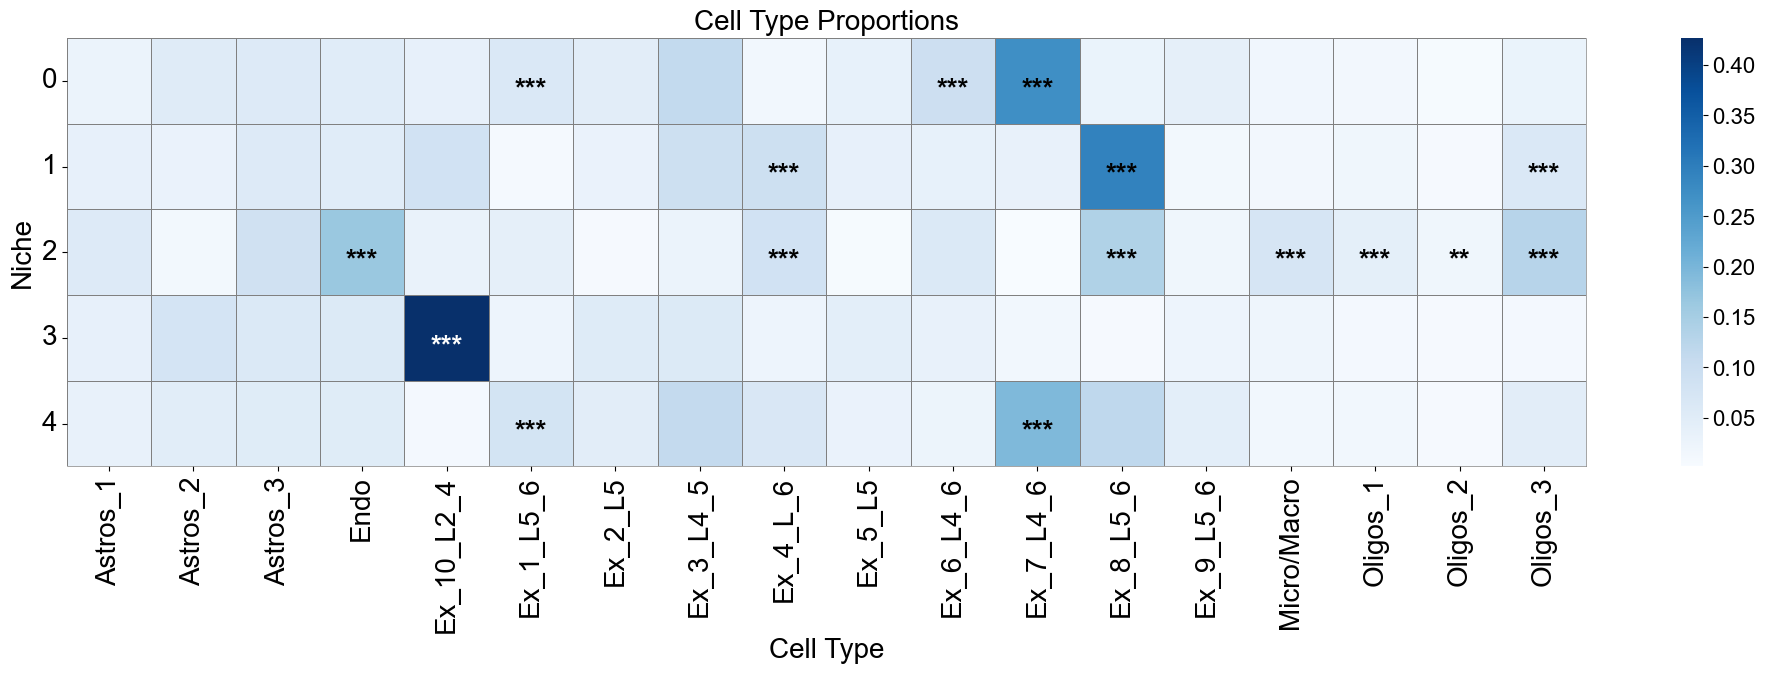

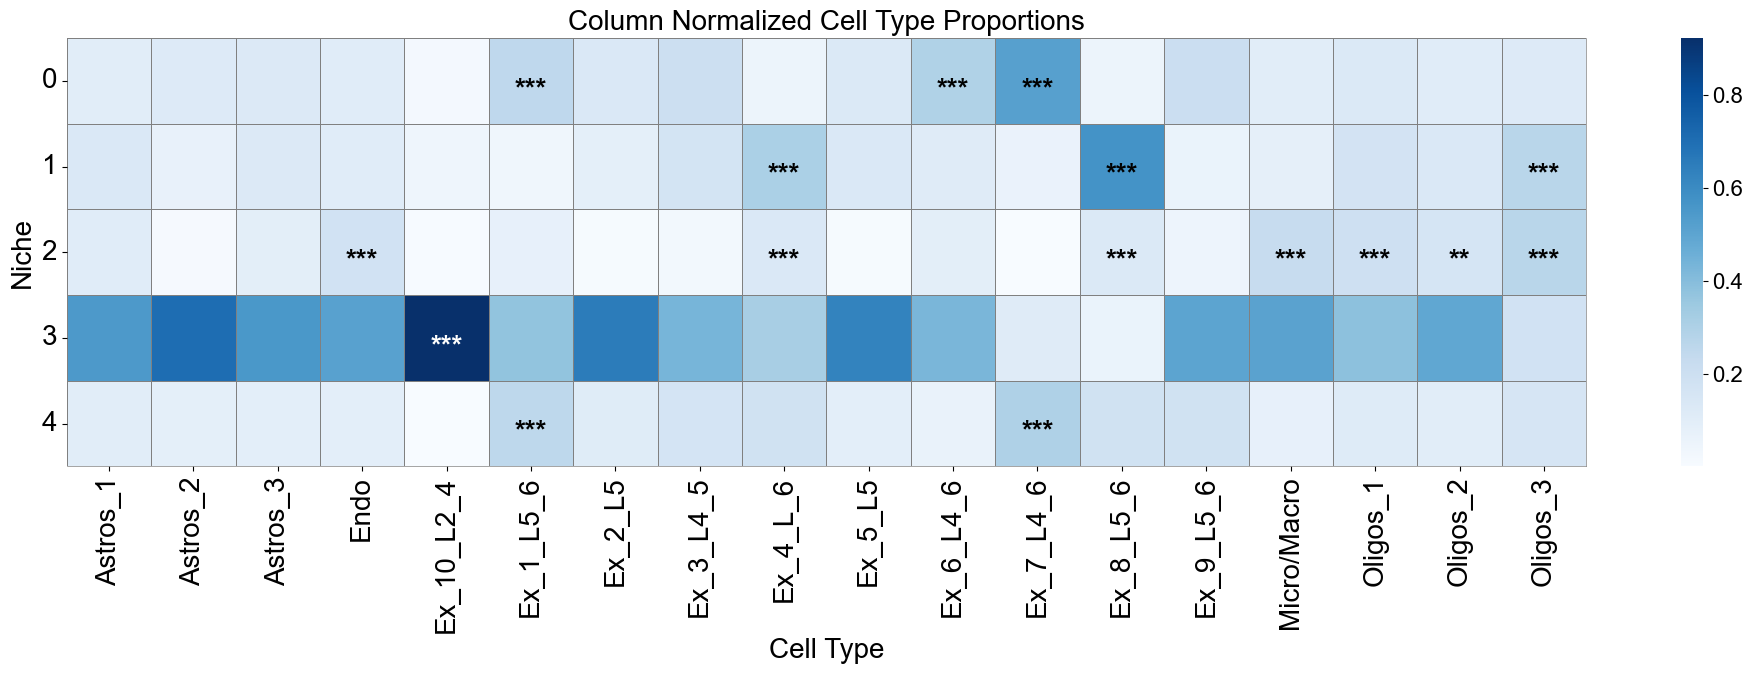

In [892]:
niche_labels = adata_concat_new.uns['niche_label_summary'].copy()
ct_labels = celltype_list_use

matrix_df = pd.DataFrame(
    data=adata_concat_new.uns['niche_dist'].toarray(),
    index=niche_labels,
    columns=ct_labels,
)

cn_dist_count = adata_concat_new.uns['niche_dist'].toarray() * adata_concat_new.uns['niche_cell_count'][:, np.newaxis]
cn_dist_norm = cn_dist_count / np.sum(cn_dist_count, axis=0)
matrix_df_norm = pd.DataFrame(
    data=cn_dist_norm,
    index=niche_labels,
    columns=ct_labels,
)

ct_df['stars'] = ct_df['q-value'].apply(p2stars)

stars_df = pd.DataFrame(
    '', 
    index=matrix_df.index, 
    columns=matrix_df.columns
)

for _, row in ct_df[ct_df['enrichment']].iterrows():
    niche = row['niche']
    ct    = row['celltype']
    if (niche in stars_df.index) and (ct in stars_df.columns):
        stars_df.loc[niche, ct] = row['stars']


fig, axes = plt.subplots(1, 1, figsize=(20, 7))

sns_heatmap_0 = sns.heatmap(
    matrix_df, 
    cmap='Blues', 
    # cbar_kws={'label': 'Cell type proportion'}, 
    linewidths=0.5,
    linecolor='gray',
    # square=True,
    ax=axes
)

for i, niche in enumerate(matrix_df.index):
    for j, ct in enumerate(matrix_df.columns):
        star = stars_df.iloc[i, j]
        if star:
            if matrix_df.iloc[i, j] > np.max(matrix_df.values) * 0.7:
                color='white'
            else:
                color='black'
            axes.text(j + 0.5, i + 0.6, star, ha='center', va='center', color=color, fontsize=20, fontweight='bold')

n_rows, n_cols = matrix_df.shape
axes.plot([0, n_cols], [n_rows, n_rows], color='gray', linewidth=0.5, clip_on=False) 
axes.plot([n_cols, n_cols], [0, n_rows], color='gray', linewidth=0.5, clip_on=False)  

axes.set_xticklabels(axes.get_xticklabels(), rotation=90, ha='center', fontsize=20)
axes.set_yticklabels(axes.get_yticklabels(), rotation=0, ha='right', fontsize=20)
axes.set_ylabel('Niche', fontsize=20)
axes.set_xlabel('Cell Type', fontsize=20)
axes.set_title('Cell Type Proportions', fontsize=20)
axes.collections[0].colorbar.ax.yaxis.label.set_size(20)
axes.collections[0].colorbar.ax.tick_params(labelsize=16)
axes.grid(False)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(20, 7))

sns_heatmap_1 = sns.heatmap(
    matrix_df_norm, 
    cmap='Blues', 
    # cbar_kws={'label': 'Cell type proportion'}, 
    linewidths=0.5,
    linecolor='gray',
    # square=True,
    ax=axes
)

for i, niche in enumerate(matrix_df.index):
    for j, ct in enumerate(matrix_df.columns):
        star = stars_df.iloc[i, j]
        if star:
            if matrix_df_norm.iloc[i, j] > np.max(matrix_df_norm.values) * 0.7:
                color='white'
            else:
                color='black'
            axes.text(j + 0.5, i + 0.6, star, ha='center', va='center', color=color, fontsize=20, fontweight='bold')

n_rows, n_cols = matrix_df.shape
axes.plot([0, n_cols], [n_rows, n_rows], color='gray', linewidth=0.5, clip_on=False) 
axes.plot([n_cols, n_cols], [0, n_rows], color='gray', linewidth=0.5, clip_on=False)  

axes.set_xticklabels(axes.get_xticklabels(), rotation=90, ha='center', fontsize=20)
axes.set_yticklabels(axes.get_yticklabels(), rotation=0, ha='right', fontsize=20)
axes.set_ylabel('Niche', fontsize=20)
axes.set_xlabel('Cell Type', fontsize=20)
axes.set_title('Column Normalized Cell Type Proportions', fontsize=20)
axes.collections[0].colorbar.ax.yaxis.label.set_size(20)
axes.collections[0].colorbar.ax.tick_params(labelsize=16)
axes.grid(False)

plt.tight_layout()
plt.show()